Trajectory Visualisation
======

**NOTE: Before running this notebook, please run script `src/ijcai15_setup.py` to setup data properly.**

Visualise trajectories on maps by generating a KML file for each trajectory.

1. [Prepare Data](#sec1)
  1. [Load Trajectory Data](#sec1.1)
  1. [Compute POI Info](#sec1.2)
  1. [Construct Travelling Sequences](#sec1.3)
  1. [Generate KML File for Trajectory](#sec1.4)
1. [Trajectory with same (start, end)](#sec2)
1. [Trajectory with more than one occurrence](#sec3)
1. [Visualise Trajectory](#sec4)
  1. [Visualise Trajectories with more than one occurrence](#sec4.1)
  1. [Visualise Trajectories with same (start, end) but different paths](#sec4.2)
1. [Visualise the Most Common Edges](#sec5)
  1. [Count the occurrence of edges](#sec5.1)

<a id='sec1'></a>

# 1. Prepare Data

<a id='sec1.1'></a>

## 1.1 Load Trajectory Data

In [160]:
%matplotlib inline

import os
import re
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from fastkml import kml, styles
from shapely.geometry import Point, LineString

In [161]:
random.seed(123456789)

In [162]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [163]:
suffix = fvisit.split('-')[-1].split('.')[0]

In [164]:
visits = pd.read_csv(fvisit, sep=';')
visits.head()

,photoID,userID,dateTaken,poiID,poiTheme,poiFreq,seqID
0,7941504100,10007579@N00,1346844688,30,Structure,1538,1
1,4886005532,10012675@N05,1142731848,6,Cultural,986,2
2,4886006468,10012675@N05,1142732248,6,Cultural,986,2
3,4885404441,10012675@N05,1142732373,6,Cultural,986,2
4,4886008334,10012675@N05,1142732445,6,Cultural,986,2


In [165]:
coords = pd.read_csv(fcoord, sep=';')
coords.head()

,photoID,photoLon,photoLat
0,7941504100,-79.380844,43.645641
1,4886005532,-79.391525,43.654335
2,4886006468,-79.391525,43.654335
3,4885404441,-79.391525,43.654335
4,4886008334,-79.391525,43.654335


In [166]:
# merge data frames according to column 'photoID'
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID')
traj.head()

,photoID,userID,dateTaken,poiID,poiTheme,poiFreq,seqID,photoLon,photoLat
0,7941504100,10007579@N00,1346844688,30,Structure,1538,1,-79.380844,43.645641
1,4886005532,10012675@N05,1142731848,6,Cultural,986,2,-79.391525,43.654335
2,4886006468,10012675@N05,1142732248,6,Cultural,986,2,-79.391525,43.654335
3,4885404441,10012675@N05,1142732373,6,Cultural,986,2,-79.391525,43.654335
4,4886008334,10012675@N05,1142732445,6,Cultural,986,2,-79.391525,43.654335


In [167]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
pd.DataFrame([num_photo, num_user, num_seq, num_poi, num_photo/num_user, num_seq/num_user], \
             index = ['#photo', '#user', '#seq', '#poi', '#photo/user', '#seq/user'], columns=[str(suffix)])

,Toro
#photo,39419.000000
#user,1395.000000
#seq,6057.000000
#poi,29.000000
#photo/user,28.257348
#seq/user,4.341935


<a id='sec3.2'></a>

<a id='sec1.2'></a>

## 1.2 Compute POI Info

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [168]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').agg(np.mean)
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)
poi_coords.head()

,poiID,poiLon,poiLat
0,1,-79.379243,43.643183
1,2,-79.418634,43.632772
2,3,-79.380045,43.662175
3,4,-79.389290,43.641297
4,6,-79.392396,43.653662


Extract POI category and visiting frequency.

In [169]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)
poi_catfreq.head()

,poiID,poiTheme,poiFreq
0,1,Sport,3506
1,2,Sport,609
2,3,Sport,688
3,4,Sport,3056
4,6,Cultural,986


In [170]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
poi_all.head()

,poiTheme,poiFreq,poiLon,poiLat
poiID,,,,
1,Sport,3506,-79.379243,43.643183
2,Sport,609,-79.418634,43.632772
3,Sport,688,-79.380045,43.662175
4,Sport,3056,-79.389290,43.641297
6,Cultural,986,-79.392396,43.653662


<a id='sec1.3'></a>

## 1.3 Construct Travelling Sequences

In [171]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy()\
          .groupby(['userID', 'seqID', 'poiID']).agg([np.min, np.max])
seq_all.columns = seq_all.columns.droplevel()
seq_all.reset_index(inplace=True)
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,poiDuration(sec)
0,10007579@N00,1,30,1346844688,1346844688,0
1,10012675@N05,2,6,1142731848,1142732445,597
2,10012675@N05,3,6,1142916492,1142916492,0
3,10012675@N05,4,13,1319327174,1319332848,5674
4,10014440@N06,5,24,1196128621,1196128878,257


<a id='sec1.4'></a>

## 1.4 Generate KML File for Trajectory

Visualise Trajectory on map by generating a KML file for a trajectory and its associated POIs.

In [172]:
def generate_kml(fname, seqid_set, seq_all, poi_all):
    k = kml.KML()
    ns = '{http://www.opengis.net/kml/2.2}'
    styid = 'style1'
    # colors in KML: aabbggrr, aa=00 is fully transparent
    sty = styles.Style(id=styid, styles=[styles.LineStyle(color='9f0000ff', width=2)]) # transparent red
    doc = kml.Document(ns, '1', 'Trajectory', 'Trajectory visualization', styles=[sty])
    k.append(doc)
    
    poi_set = set()
    seq_dict = dict()
    for seqid in seqid_set:
        # ordered POIs in sequence
        seqi = seq_all[seq_all['seqID'] == seqid].copy()
        seqi.sort(columns=['arrivalTime'], ascending=True, inplace=True)
        seq = seqi['poiID'].tolist()
        seq_dict[seqid] = seq
        for poi in seq: poi_set.add(poi)
    
    # Placemark for trajectory
    for seqid in sorted(seq_dict.keys()):
        seq = seq_dict[seqid]
        desc = 'Trajectory: ' + str(seq[0]) + '->' + str(seq[-1])
        pm = kml.Placemark(ns, str(seqid), 'Trajectory ' + str(seqid), desc, styleUrl='#' + styid)
        pm.geometry = LineString([(poi_all.loc[x, 'poiLon'], poi_all.loc[x, 'poiLat']) for x in seq])
        doc.append(pm)
    
    # Placemark for POI
    for poi in sorted(poi_set):
        desc = 'POI of category ' + poi_all.loc[poi, 'poiTheme']
        pm = kml.Placemark(ns, str(poi), 'POI ' + str(poi), desc, styleUrl='#' + styid)
        pm.geometry = Point(poi_all.loc[poi, 'poiLon'], poi_all.loc[poi, 'poiLat'])
        doc.append(pm)
        
    # save to file
    kmlstr = k.to_string(prettyprint=True)
    with open(fname, 'w') as f:
        f.write('<?xml version="1.0" encoding="UTF-8"?>\n')
        f.write(kmlstr)

<a id='sec2'></a>

# 2. Trajectory with same (start, end)

In [173]:
seq_user = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_user.reset_index(inplace=True)
seq_user.rename(columns={'size':'seqLen'}, inplace=True)
seq_user.set_index('seqID', inplace=True)
seq_user.head()

,userID,poiID
seqID,,
1,10007579@N00,1
2,10012675@N05,1
3,10012675@N05,1
4,10012675@N05,1
5,10014440@N06,1


In [174]:
def extract_seq(seqid, seq_all):
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort(columns=['arrivalTime'], ascending=True, inplace=True)
    return seqi['poiID'].tolist()

In [175]:
startend_dict = dict()
for seqid in seq_all['seqID'].unique():
    seq = extract_seq(seqid, seq_all)
    if (seq[0], seq[-1]) not in startend_dict:
        startend_dict[(seq[0], seq[-1])] = [seqid]
    else:
        startend_dict[(seq[0], seq[-1])].append(seqid)

In [176]:
indices = sorted(startend_dict.keys())
columns = ['#traj', '#user']
startend_seq = pd.DataFrame(data=np.zeros((len(indices), len(columns))), index=indices, columns=columns)

In [177]:
for pair, seqid_set in startend_dict.items():
    users = set([seq_user.loc[x, 'userID'] for x in seqid_set])
    startend_seq.loc[pair, '#traj'] = len(seqid_set)
    startend_seq.loc[pair, '#user'] = len(users)

In [178]:
startend_seq.sort(columns=['#traj'], ascending=True, inplace=True)
startend_seq.index.name = '(start, end)'
startend_seq.sort_index(inplace=True)
print(startend_seq.shape)
startend_seq

(280, 2)


,#traj,#user
"(start, end)",,
"(1, 1)",242,92
"(1, 4)",1,1
"(1, 7)",3,3
"(1, 8)",2,2
"(1, 16)",2,2
"(1, 19)",1,1
"(1, 21)",3,3
"(1, 22)",1,1
"(1, 23)",1,1


<a id='sec3'></a>

# 3. Trajectory with more than one occurrence

Contruct trajectories with more than one occurrence (can be same or different user).

In [179]:
distinct_seq = dict()

In [180]:
for seqid in seq_all['seqID'].unique():
    seq = extract_seq(seqid, seq_all)
    #if len(seq) < 2: continue  # drop trajectory with single point
    if str(seq) not in distinct_seq:
        distinct_seq[str(seq)] = [(seqid, seq_user.loc[seqid].iloc[0])] # (seqid, user)
    else:
        distinct_seq[str(seq)].append((seqid, seq_user.loc[seqid].iloc[0]))

In [181]:
print(len(distinct_seq))
#distinct_seq

519


In [182]:
distinct_seq_df = pd.DataFrame.from_dict({k:len(distinct_seq[k]) for k in sorted(distinct_seq.keys())}, orient='index')
distinct_seq_df.columns = ['#occurrence']
distinct_seq_df.index.name = 'trajectory'
distinct_seq_df['seqLen'] = [len(x.split(',')) for x in distinct_seq_df.index]
distinct_seq_df.sort_index(inplace=True)
print(distinct_seq_df.shape)
distinct_seq_df.head()

(519, 2)


,#occurrence,seqLen
trajectory,,
"[1, 16]",2,2
"[1, 19]",1,2
"[1, 21]",3,2
"[1, 22]",1,2
"[1, 23]",1,2


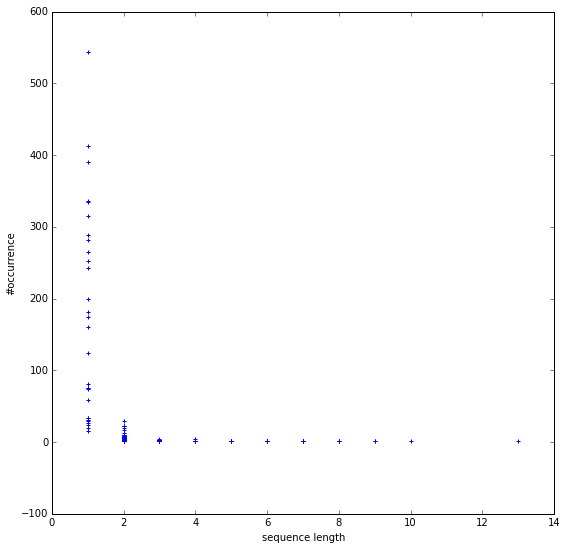

In [183]:
plt.figure(figsize=[9, 9])
plt.xlabel('sequence length')
plt.ylabel('#occurrence')
plt.scatter(distinct_seq_df['seqLen'], distinct_seq_df['#occurrence'], marker='+')

Filtering out sequences with single point as well as sequences occurs only once.

In [184]:
distinct_seq_df2 = distinct_seq_df[distinct_seq_df['seqLen'] > 1]
distinct_seq_df2 = distinct_seq_df2[distinct_seq_df2['#occurrence'] > 1]
distinct_seq_df2.head()

,#occurrence,seqLen
trajectory,,
"[1, 16]",2,2
"[1, 21]",3,2
"[1, 24]",2,2
"[1, 30, 7]",2,3
"[1, 30]",6,2


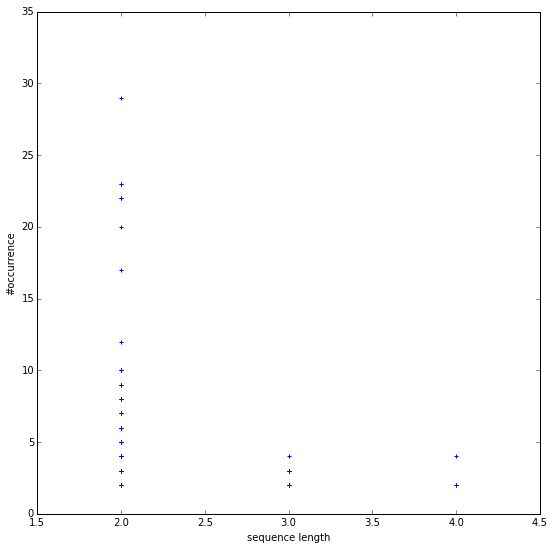

In [185]:
plt.figure(figsize=[9, 9])
plt.xlabel('sequence length')
plt.ylabel('#occurrence')
plt.scatter(distinct_seq_df2['seqLen'], distinct_seq_df2['#occurrence'], marker='+')

<a id='sec4'></a>

# 4. Visualise Trajectory

<a id='sec4.1'></a>

## 4.1 Visualise Trajectories with more than one occurrence

In [186]:
for seqstr in distinct_seq_df2.index:
    assert(seqstr in distinct_seq)
    seqid = distinct_seq[seqstr][0][0]
    fname = re.sub(',', '_', re.sub('[ \[\]]', '', seqstr))
    fname = os.path.join(data_dir, suffix + '-seq-occur-' + str(len(distinct_seq[seqstr])) + '_' + fname + '.kml')
    generate_kml(fname, [seqid], seq_all, poi_all)

<a id='sec4.2'></a>

## 4.2 Visualise Trajectories with same (start, end) but different paths

In [144]:
startend_distinct_seq = dict()

In [145]:
distinct_seqid_set = [distinct_seq[x][0][0] for x in distinct_seq_df2.index]

In [146]:
for seqid in distinct_seqid_set:
    seq = extract_seq(seqid, seq_all)
    if (seq[0], seq[-1]) not in startend_distinct_seq:
        startend_distinct_seq[(seq[0], seq[-1])] = [seqid]
    else:
        startend_distinct_seq[(seq[0], seq[-1])].append(seqid)

In [159]:
for pair in sorted(startend_distinct_seq.keys()):
    if len(startend_distinct_seq[pair]) < 2: continue
    fname = suffix + '-seq-start_' + str(pair[0]) + '_end_' + str(pair[1]) + '.kml'
    fname = os.path.join(data_dir, fname)
    print(pair, len(startend_distinct_seq[pair]))
    generate_kml(fname, startend_distinct_seq[pair], seq_all, poi_all)

(2, 17) 2
(8, 16) 2
(16, 7) 2
(16, 8) 2
(17, 14) 2
(21, 22) 2
(21, 28) 3
(22, 21) 3
(22, 23) 2
(22, 28) 2
(22, 30) 2
(23, 16) 2
(23, 21) 3
(23, 22) 3
(23, 28) 2
(28, 21) 3
(28, 22) 2
(28, 23) 2
(28, 30) 2


<a id='sec5'></a>

# 5. Visualise the Most Common Edges

<a id='sec5.1'></a>

## 5.1 Count the occurrence of edges

In [148]:
edge_count = pd.DataFrame(data=np.zeros((poi_all.index.shape[0], poi_all.index.shape[0]), dtype=np.int), \
                          index=poi_all.index, columns=poi_all.index)

In [149]:
for seqid in seq_all['seqID'].unique():
    seq = extract_seq(seqid, seq_all)
    for j in range(len(seq)-1):
        edge_count.loc[seq[j], seq[j+1]] += 1

In [150]:
edge_count

poiID,1,2,3,4,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
poiID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,1,0,5,7,0,0,0,...,3,2,1,2,0,0,0,0,2,9
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,0,...,11,1,4,1,0,0,0,0,2,3
4,4,1,0,0,1,0,6,0,1,0,...,1,4,0,3,1,0,0,0,0,5
6,0,0,1,1,0,2,0,0,0,8,...,8,13,2,1,10,0,1,2,2,2
7,7,0,1,1,3,0,2,0,0,4,...,14,11,14,3,1,0,2,15,0,42
8,0,0,1,7,1,2,0,0,0,0,...,4,2,2,4,0,0,0,4,0,15
9,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10,1,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0


In [151]:
k = kml.KML()
ns = '{http://www.opengis.net/kml/2.2}'
width_set = set()

# Placemark for edges
pm_list = []
for poi1 in poi_all.index:
    for poi2 in poi_all.index:
        width = edge_count.loc[poi1, poi2]
        if width < 1: continue
        width_set.add(width)
        sid = str(poi1) + '_' + str(poi2)
        desc = 'Edge: ' + str(poi1) + '->' + str(poi2) + ', #occurrence: ' + str(width)
        pm = kml.Placemark(ns, sid, 'Edge_' + sid, desc, styleUrl='#sty' + str(width))
        pm.geometry = LineString([(poi_all.loc[x, 'poiLon'], poi_all.loc[x, 'poiLat']) for x in [poi1, poi2]])
        pm_list.append(pm)

# Placemark for POIs
for poi in poi_all.index:
    sid = str(poi)
    desc = 'POI of category ' + poi_all.loc[poi, 'poiTheme']
    pm = kml.Placemark(ns, sid, 'POI_' + sid, desc, styleUrl='#sty1')
    pm.geometry = Point(poi_all.loc[poi, 'poiLon'], poi_all.loc[poi, 'poiLat'])
    pm_list.append(pm)

# Styles
stys = []
for width in width_set:
    sid = 'sty' + str(width)
    # colors in KML: aabbggrr, aa=00 is fully transparent
    stys.append(styles.Style(id=sid, styles=[styles.LineStyle(color='3f0000ff', width=width)])) # transparent red

doc = kml.Document(ns, '1', 'Edges', 'Edge visualization', styles=stys)
for pm in pm_list: doc.append(pm)
k.append(doc)

# save to file
fname = suffix + '-common_edges.kml'
fname = os.path.join(data_dir, fname)
kmlstr = k.to_string(prettyprint=True)
with open(fname, 'w') as f:
    f.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    f.write(kmlstr)

An example map for Toronto is available [here](https://www.google.com/maps/d/edit?mid=zbfVMoawlt38.kpkGxSPKi7HM&usp=sharing).